## Shocks to Inflation

This notebook constructs all shocks to inflation used to explore conditional responses of inflation expectations

- Oil shocks: Hamilton (1996) （no need for SVAR)
- Technology shocks: Gali(1999) and Francis et al.(2014)
- News shocks: Sims et al.(2014)
- Monetary policy shocks: unexpected funds rate change and future change (reference to be added)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
from numpy import linalg as LA
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.tsa.vector_ar.irf import BaseIRAnalysis
from statsmodels.tsa.base.datetools import dates_from_str
import statsmodels.tsa.vector_ar.plotting as plotting

from scipy.stats import pearsonr as prs

from scipy.optimize import minimize

### Tech shocks identified via SVAR with long-run restrictions (Gali (1999))

A vector of variables: $\Delta x_t$, $\Delta n_t$ and $\pi_t$

$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] = \left[\begin{array} \\ C(L)_{11}, C(L)_{12}, C(L)_{13} \\ C(L)_{21}, C(L)_{22}, C(L)_{23} \\ C(L)_{31}, C(L)_{32}, C(L)_{33} \end{array}  \right]   \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

Identification restriction is 

- Orthogonality + normalization: $E(\epsilon \epsilon')= I$   
- $C(1)_{12}=0$
- $C(1)_{13}=0$
- $C(1)_{23}=0$

Then $C(L)$ is lower triangluar and just identified. This is so called long-run restrictions from Blanchard and Quah (1989). 

Rewriting it into a general form of SVAR, we have  

$$A(L) \left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =\left[\begin{array} \\ u_t^z \\ u^m_t \\ u^\pi_t  \end{array}\right]  =B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

where $u_t$ is reduced form residul and $\epsilon_t$ is structural shock. 


$$\left[\begin{array} \\\Delta x_t\\ \Delta n_t \\ \pi_t  \end{array}\right] =A(L)^{-1} B \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] = \mathbf{C}(L) \left[\begin{array} \\ \epsilon_t^z \\ \epsilon^m_t \\ \epsilon^\pi_t  \end{array}\right] $$

With $p$ lags, we have $$A(L) = I_k - A_1L - A_2L^2-\ldots - A_pL^p$$

The estimation takes following steps. 

1. Estimate OLS to get estimates $\hat A_1, \hat A_2, \ldots, \hat A_p$ and $\hat \Sigma^u$.

2. Use the following to sovle $\hat B$, $$\underbrace{(I_k - \hat A_1 - \ldots - \hat A_p)^{-1}}_{\hat A(1)} \hat B = Col((I_k - \hat A_1 - \ldots - \hat A_p)\hat \Sigma^u(I_k - \hat A'_1 - \ldots - \hat A'_p)^{-1})$$ 

The existing SVAR package in *statsmodels* only handles cases with direct zero restrictions on $B$ matrices. Therefore I write my own codes using long-run restrictions here.  

In [2]:
## loading technology shock data
ts_data = pd.read_excel('../OtherData/Emp.xls',sheet_name='data')
ts_data2 = pd.read_excel('../OtherData/EmpSaQ.xls',sheet_name='data')
ts_data['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')
ts_data2['observation_date'] = pd.to_datetime(ts_data['observation_date'],format='%Y%m%d')


## streamline the dates in correct formats
datesQ1 = ts_data['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ1 = dates_from_str(datesQ1)

datesQ2 = ts_data2['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + ts_data['observation_date'].dt.quarter.astype(int).astype(str)
datesQ2 = dates_from_str(datesQ2)

## loading inflation data and converting from monthly to quarterly
inf_dataM = pd.read_stata('../OtherData/InfM.dta')
filterQ = inf_dataM['month'].isin([3,6,9,12])
inf_dataQ = inf_dataM[filterQ]
infQ = inf_dataQ['CPIAU'].pct_change()
inf_datesQ = inf_dataQ['date'].dt.year.astype(int).astype(str) + \
             "Q" + inf_dataQ['date'].dt.quarter.astype(int).astype(str)
inf_datesQ = dates_from_str(inf_datesQ)

In [3]:
# set date index to productivity and labor series
ts_var1 = ts_data[['DLPROD1','DLHOURS']]
ts_var2 = ts_data2[['DLPROD2','DLEMP']]

ts_var1.index = pd.DatetimeIndex(datesQ1,freq='Q')
ts_var2.index = pd.DatetimeIndex(datesQ2,freq='Q')

# set date index to inf series 
infQ.index= pd.DatetimeIndex(inf_datesQ)

In [4]:
## merge with inflation
# order of vector for var:  [productivity, labor input, inflation]
ts_var1 = pd.concat([ts_var1,infQ], join='inner', axis=1)
ts_var2 = pd.concat([ts_var2,infQ], join='inner', axis=1)

ts_var1=ts_var1.copy().dropna()
ts_var2=ts_var2.copy().dropna()

In [5]:
# period filter 
start_t='1948-01-01'
end_t = '1994-12-30'   # the same period as in Gali (1991)

ts_var1=ts_var1.copy().loc[start_t:end_t]
ts_var2=ts_var2.copy().loc[start_t:end_t]

# Estimate reduced VAR 
model1 = VAR(ts_var1)  # var model with no restriction
model2 =VAR(ts_var2)   # var model2 with no restriction

#svmodel1=SVAR(ts_var1.loc[start_t:end_t],svar_type='B',\
 #             B=np.array([['E',0,0],['E','E',0],['E','E','E']]))  # svar model with restriction
#svmodel2=SVAR(ts_var2.loc[start_t:end_t],svar_type='B',\
              # B=np.array([['E',0],['E','E']]))  # svar model with restriction

In [6]:
## Checks the data 

## Pearson test of correlation 
prs1_pval=prs(ts_var1.iloc[:,0],ts_var1.iloc[:,1])[1]
prs2_pval=prs(ts_var2.iloc[:,0],ts_var2.iloc[:,1])[1]

print('Model1: using total non-farm hours as labor inputs measure')
print('Sample mean:\n'+str(ts_var1.mean()))
print('Correlation coefficients of series\n'+str(ts_var1.corr()))
print('The p-value of Pearson Test on the correlation of productivity and labor input is '+str(round(prs1_pval,3)))

print('Model2: using civil employment as labor inputs measure')
print('Sample mean:\n'+str(ts_var2.mean()))
print('Correlation coefficients of series\n'+str(ts_var2.corr()))
if prs2_pval !='NaN':
    print('The p-value of Pearson Test on the correlation of productivity and labor input is '+str(round(prs2_pval,3)))

Model1: using total non-farm hours as labor inputs measure
Sample mean:
DLPROD1    0.002172
DLHOURS    0.001577
CPIAU      0.010031
dtype: float64
Correlation coefficients of series
          DLPROD1  DLHOURS     CPIAU
DLPROD1  1.000000 -0.24954 -0.275457
DLHOURS -0.249540  1.00000  0.086060
CPIAU   -0.275457  0.08606  1.000000
The p-value of Pearson Test on the correlation of productivity and labor input is 0.001
Model2: using civil employment as labor inputs measure
Sample mean:
DLPROD2    0.001987
DLEMP      0.001761
CPIAU      0.010031
dtype: float64
Correlation coefficients of series
          DLPROD2     DLEMP     CPIAU
DLPROD2  1.000000  0.035533 -0.205380
DLEMP    0.035533  1.000000  0.110855
CPIAU   -0.205380  0.110855  1.000000
The p-value of Pearson Test on the correlation of productivity and labor input is 0.63


In [7]:
rs1=model1.fit(4)
#rs1=model1.fit(ic='bic')
#rs2=model2.fit(ic='bic')
#srs1=svmodel1.fit(4)
#srs2=svmodel2.fit(4,solver='nm')

In [8]:
rs1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Jun, 2019
Time:                     10:24:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -32.6646
Nobs:                     182.000    HQIC:                  -33.0729
Log likelihood:           2299.22    FPE:                3.28147e-15
AIC:                     -33.3512    Det(Omega_mle):     2.66795e-15
--------------------------------------------------------------------
Results for equation DLPROD1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.003552         0.000666            5.333           0.000
L1.DLPROD1        -0.120522         0.079403           -1.518           0.129
L1.DLHOURS        -0.125325         0.073261           -1.711         

In [9]:
## define function of Blanchard and Quah long-run restriction

def SVAR_BQLR(rs):
    """
    inputs
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    
    outputs
    -------
    dictionary:
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals 
      B_est:   ndarray
               estimated B matrices using long-run restrictions
      eps_est: ndarray
               estimated structural shocks
      A_L:     ndarray
               I_k - A_1 - \ldots -A_p
      C_L:     adarray 
               A_L.inv * B
      nlags:   int
               number of lags 
      residuals: ndarray
               reduced var residuals 
      ...
    """

    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u 
    u = np.array(rs1.resid)

    ## Estimate B matrices 
    I_k = np.eye(k)
    var_coefs=rs1.coefs   # p x k x k 
    A1 = I_k
    A1_prime = I_k
    for i in range(len(var_coefs)):
        #print(A_L)
        A1 = A1 - var_coefs[i,:,:]
        #print(A_L_prime)
        A1_prime = A1_prime - var_coefs[i,:,:].T
        
        B_svar_est = np.dot(A1,LA.cholesky(
            np.dot(
                np.dot(LA.inv(A1),
                       sigma_u),
                LA.inv(A1_prime))
        )
                           )
        #print('Estimated B matrice is \n'+str(B_svar_est))
        ## check if the restrictions hold
        
        C1=np.dot(LA.inv(A1),B_svar_est)
        if np.allclose(C1, np.tril(C1)):
            print('C1 is indeed lower triangular, consistent with long-run restriction')
        else:
            print('Something is wrong: C1 is not lower triangular, inconsistent with long-run restriction')

        
        ## structural shocks 
        epsilon_est = np.dot(LA.inv(B_svar_est),(np.array(rs1.resid).T))
          
        ## impulse response 
        #IR_svar = np.kron(var_coefs,B_svar_est)
        #print(IR_svar.shape)
        
        return {'var_coefs':var_coefs,'sigma_u':sigma_u,'B_est':B_svar_est,\
                'eps_est':epsilon_est,'A1':A1,'C1':C1,'nlags':nlags, 'neqs': k,\
                'residuals':u}

In [10]:
### Invokes BQLR 

SVAR_rst = SVAR_BQLR(rs1)
var_coefs_est,A1,C1,sigma_u,B_svar_est,epsilon_est,nlags,neqs,residuals = (SVAR_rst['var_coefs'],SVAR_rst['A1'],\
                                                                             SVAR_rst['C1'],SVAR_rst['sigma_u'], \
                                                                             SVAR_rst['B_est'],SVAR_rst['eps_est'],\
                                                                             SVAR_rst['nlags'],SVAR_rst['neqs'],\
                                                                             SVAR_rst['residuals'])

C1 is indeed lower triangular, consistent with long-run restriction


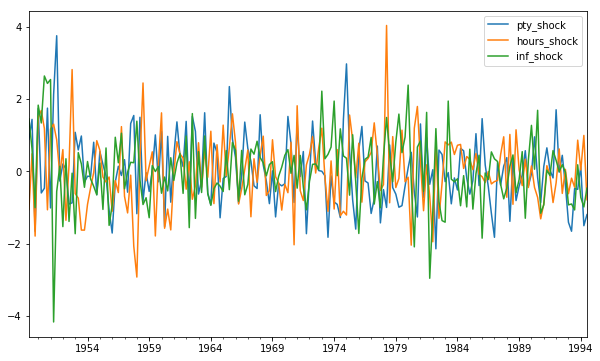

In [11]:
## Look into the structural shocks epsilon

str_shocks_est=pd.DataFrame(epsilon_est.T)
str_shocks_est.index=ts_var1.index[nlags:]
if str_shocks_est.shape[1]==3:
    str_shocks_est.columns=['pty_shock','hours_shock','inf_shock']
if str_shocks_est.shape[1]==2:
    str_shocks_est.columns=['productivity','hours']
str_shocks_est.plot(figsize=(10,6))

In [12]:
def ma_rep(coefs, maxn=10):
    """
    MA(\infty) representation of VAR(p) process
    Parameters
    ----------
    coefs : ndarray (p x k x k)
    maxn : int
        Number of MA matrices to compute
    Notes
    -----
    VAR(p) process as
    .. math:: y_t = A_1 y_{t-1} + \ldots + A_p y_{t-p} + u_t
    can be equivalently represented as
    .. math:: y_t = \mu + \sum_{i=0}^\infty \Phi_i u_{t-i}
    e.g. can recursively compute the \Phi_i matrices with \Phi_0 = I_k
    Returns
    -------
    phis : ndarray (maxn + 1 x k x k)
    """
    p, k, k = coefs.shape
    phis = np.zeros((maxn+1, k, k))
    phis[0] = np.eye(k)
    # recursively compute Phi matrices
    for i in range(1, maxn + 1):
        for j in range(1, i+1):
            if j > p:
                break
                
            phis[i] += np.dot(phis[i-j], coefs[j-1])
    return phis

# 
T_irf = 10 
# compute impulse responses 
ma_mats = ma_rep(var_coefs_est,maxn=T_irf)  

A_svar_est = np.eye(neqs)   # A is identity matrix by assumption
P = np.dot(LA.inv(A_svar_est), B_svar_est) 

## ma_rep to svar_ma_rep

svar_ma_rep = np.array([np.dot(coefs, P) for coefs in ma_mats])  # T+1 x k x k 

In [ ]:
## generate m-c confidence bands 

def sirf_errband_mc(self, orth=False, repl=1000, T=10,
signif=0.05, seed=None, burn=100, cum=False):
"""
        Compute Monte Carlo integrated error bands assuming normally
        distributed for impulse response functions
        Parameters
        ----------
        orth: bool, default False
            Compute orthoganalized impulse response error bands
        repl: int
            number of Monte Carlo replications to perform
        T: int, default 10
            number of impulse response periods
        signif: float (0 < signif <1)
            Significance level for error bars, defaults to 95% CI
        seed: int
            np.random.seed for replications
        burn: int
            number of initial observations to discard for simulation
        cum: bool, default False
            produce cumulative irf error bands
        Notes
        -----
        Lütkepohl (2005) Appendix D
        Returns
        -------
        Tuple of lower and upper arrays of ma_rep monte carlo standard errors
        """
        neqs = self.neqs
        mean = self.mean()
        k_ar = self.k_ar
        coefs = self.coefs
        sigma_u = self.sigma_u
        intercept = self.intercept
        df_model = self.df_model
        nobs = self.nobs
        ma_coll = np.zeros((repl, T+1, neqs, neqs))
        A = self.A
        B = self.B
        A_mask = self.A_mask
        B_mask = self.B_mask
        A_pass = self.model.A_original
        B_pass = self.model.B_original
        s_type = self.model.svar_type
        g_list = []
def agg(impulses):
if cum:
return impulses.cumsum(axis=0)
return impulses
        opt_A = A[A_mask]
        opt_B = B[B_mask]
for i in range(repl):
# discard first hundred to correct for starting bias
            sim = util.varsim(coefs, intercept, sigma_u, seed=seed,
steps=nobs + burn)
            sim = sim[burn:]
            smod = SVAR(sim, svar_type=s_type, A=A_pass, B=B_pass)
if i == 10:
# Use first 10 to update starting val for remainder of fits
                mean_AB = np.mean(g_list, axis=0)
                split = len(A[A_mask])
                opt_A = mean_AB[:split]
                opt_B = mean_AB[split:]
            sres = smod.fit(maxlags=k_ar, A_guess=opt_A, B_guess=opt_B)
if i < 10:
# save estimates for starting val if in first 10
                g_list.append(np.append(sres.A[A_mask].tolist(),
                                        sres.B[B_mask].tolist()))
            ma_coll[i] = agg(sres.svar_ma_rep(maxn=T))
        ma_sort = np.sort(ma_coll, axis=0)  # sort to get quantiles
        index = (int(round(signif / 2 * repl) - 1),
int(round((1 - signif / 2) * repl) - 1))
        lower = ma_sort[index[0], :, :, :]
        upper = ma_sort[index[1], :, :, :]
return lower, upper

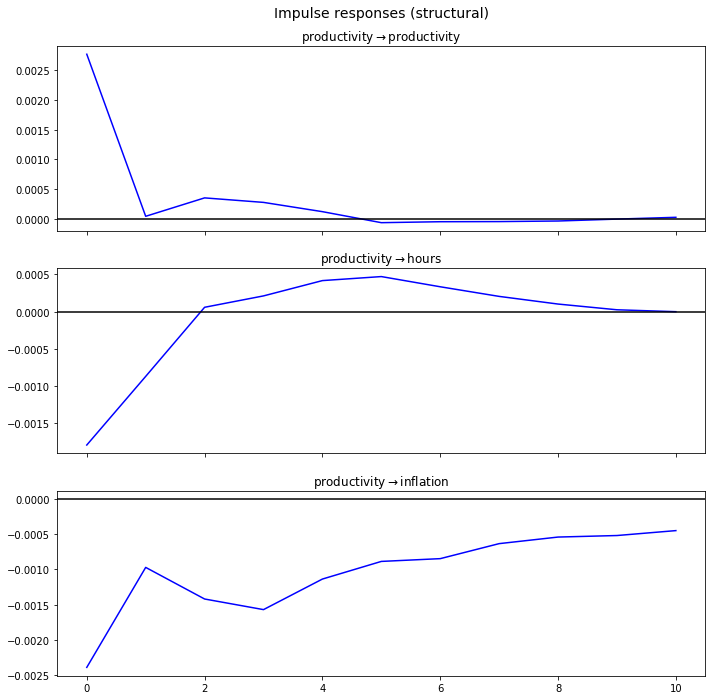

In [13]:
## IR plot parameters prepared 

## svar_ma to impulse respulse parameters

irfs = svar_ma_rep 
stderr = None  # T x k x k
impulse = 0  # int, the location of shock of interest   
response =  None  # int, the location of variable of response

if neqs==3:
    model_names= np.array(['productivity','hours','inflation'])
if neqs==2:
    model_names= np.array(['productivity','hours'])

title = 'Impulse responses (structural)'
signif =0.05
subplot_params =None
stderr_type ='asym'
plot_params={}

# plot the figure using existing module  
fig = plotting.irf_grid_plot(irfs, stderr, impulse, response,
                                     model_names, title, signif=signif,
                                     subplot_params=subplot_params,
                                     plot_params=plot_params,
                                     stderr_type=stderr_type)

Text(0, 0.5, 'non-technology shocks')

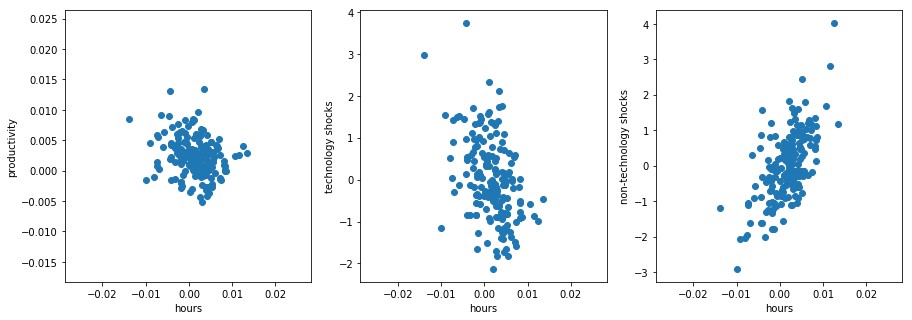

In [14]:
## replicate Gali(1999) figure 1

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ts_var1.iloc[:,1],ts_var1.iloc[:,0])
plt.xlabel('hours')
plt.ylabel('productivity')

plt.subplot(1,3,2)
plt.scatter(ts_var1.iloc[nlags:,1],str_shocks_est['pty_shock'])
plt.xlabel('hours')
plt.ylabel('technology shocks')

plt.subplot(1,3,3)
plt.scatter(ts_var1.iloc[nlags:,1],str_shocks_est['hours_shock'])
plt.xlabel('hours')
plt.ylabel('non-technology shocks')

In [15]:
#ts_plot1=rs1.plot()

### Tech shocks identified using Max-share of forecast error (Francis et al.(2014)) 

Francis et al.(2014) identified technoogy shocks in an approach shown to have less small-sample-bais than long-run restrictions. I also identify tech shocks in their approach. (Also, the news shock is identified in a very similar approach, see below.)

Again, the structural VAR can written as the following 


$$y_t =C(L)\epsilon_t = A^{-1}(L)B \epsilon_t = A^{-1}(L) u_t = D(L)u_t$$

where $y_t = [ \Delta x_t,  \Delta n_t, \pi_t  ]'$.

h-period-ahead forecast error 

$$y_{t+h}- \hat y_{t+h}= \sum^{h-1}_{\tau=0} D_\tau u_{t+h-\tau} $$

Let us assume an othogonal matrix $F$ (i.e. $F'F=I$), then we have 

$$y_{t+h}- \hat y_{t+h} = \sum^{h-1}_{\tau=0} D_\tau FF' u_{t+h-\tau}$$

The h-period-ahead variance share for a particular variable i attributed to $j$ shock is 

$$\omega_{ij}(h) = \frac{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \alpha \alpha' D_\tau'] e_i}{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \Omega_u D_\tau'] e_i }$$

where $\alpha = F e_j$, the $j$-th column of F, and $e_i$ is a $n \times 1$ vector that picks responses of $i$. 

For an exogeously chosen $h$, the technology shock is identified by solving the following problem

$$\underset{\alpha}{\text{max}}\quad \omega_{1j}(\alpha(h)) = \frac{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \alpha \alpha' D_\tau'] e_i}{e_i' [\sum^{\tau=h-1}_{\tau=0} D_\tau \Omega_u D_\tau'] e_i }$$

Once we can solve $\alpha$, we can compute the identified tech shock as 

$$\epsilon^z_t = \alpha H^{-1}u^z_t  $$

and $$H=chol(\Omega_u)$$

In [16]:
def SVAR_MaxShare(rs,h,pty_id=0,contemp=True):
    """
    inputs
    ------
    rs: result object of reduced VAR estimated using statsmodels.tsa.VAR
    h:  int 
        exogoneous forecast horizon
    pty_id: int
        position index of labor productivity, whose forecast error attributed to tech shock is to be maximized 
    
    outputs
    -------
    dict
      sigma_u: ndarrray
               variance-convariance of reduced VAR residuals
               
      nlags:   int
               number of lags 
               
      residuals: ndarray
               reduced var residuals
               
      alpha_est:   ndarray  k x 1 
               alpha_est = F'e_j where F is otho k x k matrix 
                                 and e_j is the k x 1 matrix that takes one at j-th position
      H:      ndarray
              chol(\Omega^u)
              
      eps_est: ndarray
               estimated structural shocks = alpha' H^{-1} u
      
      shares: ndarray k x 1
              shares of forecast errors of variable i attributed to different shocks 
      ...
    """
    # basic parameters passed down from reduced VAR 
    
    k = rs1.neqs    # number of equations 
    nlags =rs1.coefs.shape[0] # number of lags 
    sigma_u = rs1.sigma_u     # k x k 
    u = np.array(rs1.resid)  # k x 1 
    var_coefs = rs1.coefs   # p x k x k 
    
    # ma representations 
    maxn = h+1           # time horizon for ma representation(infty in theory, finite in practice) 
    ma_mats = ma_rep(var_coefs,maxn)   # D matrix: maxn+1 x k x k 
    
    ## compute forecast errors for horizon h
    fe_mats = np.zeros([k,k])   # k variables,thus k forecast errors  
    
    for t in range(h):
        fe_mats += np.dot(np.dot(ma_mats[t],
                                 sigma_u),
                          ma_mats[t].T)    # \sum_0^{h-1} D_tau \Sigma_u D_tau' 
    #print(fe_mats)
    eye_i = np.zeros([k,1])
    eye_i[pty_id] = 1
    fe = np.dot(np.dot(eye_i.T,
                       fe_mats),
                eye_i)
    
    # equivalent to pre and post multiply it by a selectio matrix e_i where only i-th entry is one
    
    ## estimate H matrix 
    H = LA.cholesky(sigma_u)
    
    def fe_share(alpha):
        """
        inputs
        ------
        alpha: ndarray: k x 1
               alpha = F e_j, where F is an othogonal matrix such that FF'=I
        i: int  the location of the technology shock
        outputs
        ------
        fe_share: share of forecast errors of k variables attributed to shock j 
                ndaray:  k x 1 
        """
        
        fe_contr_mats = np.zeros([k,k]) 
        
        for t in range(h):
            fe_contr_mats += np.dot(np.dot(ma_mats[t],
                                 np.dot(alpha,alpha.T)),
                          ma_mats[t].T) 
        
        fe_contr= np.dot(np.dot(eye_i.T,
                                fe_contr_mats),
                         eye_i)
        #print(fe_contr.shape)
        share = fe_contr/fe    # objective function to maximize in the max-share approach 
        
        return share
    
    ## Estimation of alpha
    
    ### objective function of alpha 
    
    obj = lambda alpha: -fe_share(alpha)
    alpha_init = np.random.rand(k,1)   
    
    
    
    ### constraint on alpha
    
    # the following 3 lines are not necessary 
    #I_k = np.identity(k)
    #e_j = np.zeros([k,1]) 
    #e_j[0] = 1       # used to pick up the j-th column of F
    
    
    def constr_eq1(alpha):
        return np.dot(alpha.T, alpha)-1  # constraint that F is ortho
    
    def constr_eq2(alpha):
        eye_ij = np.zeros([k,1])
        eye_ij[0,0] = 1
        return np.dot(eye_ij.T,alpha)

    ##
    #constr = {'type':'eq', 'fun': constr_eq1}
    constr_lst =[]
    constr_lst.append({'type':'eq', 'fun': constr_eq1})
    
    #if contemp==False:
    #    constr_lst.append( {'type':'eq', 'fun': constr_eq2})
        
    constr = tuple(constr_lst)
    ### maximization  
    alpha_est = minimize(obj,x0=alpha_init,constraints=constr)['x']
    print("Estimated alpha that maximizes the share of forecast error is "+ str(alpha_est))
    
    ## estimatd structural shocks 
    epsilon_est = np.dot(np.dot(alpha_est.T,
                                LA.inv(H)),
                         u.T)

    return {'var_coefs':var_coefs,'sigma_u':sigma_u,'fe':fe,'nlags':nlags, 'neqs': k,\
                'residuals':u,'alpha_est':alpha_est,'epsilon_est':epsilon_est}

In [17]:
## invoke max_share estimation
horizon = 40  #10 years
SVAR_maxshare_rst = SVAR_MaxShare(rs1,horizon)
tech_shock = SVAR_maxshare_rst['epsilon_est'].flatten()
alpha_est = SVAR_maxshare_rst['alpha_est']

Estimated alpha that maximizes the share of forecast error is [0.99068766 0.13081891 0.03774115]


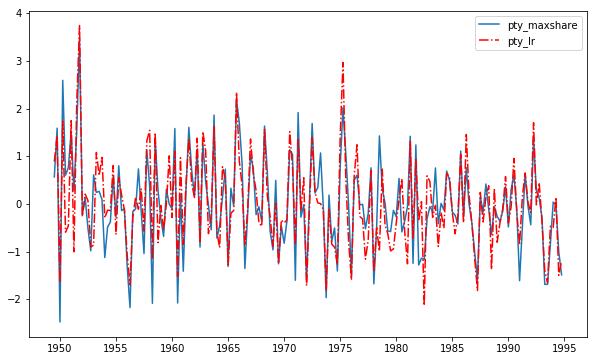

In [18]:
## save it to data frames 
str_shocks_est['pty_shock_max']=tech_shock.T

# compare two tech shocks estimated from different approaches 
plt.figure(figsize=(10,6))
plt.plot(str_shocks_est['pty_shock_max'],label='pty_maxshare')
plt.plot(str_shocks_est['pty_shock'],'r-.',label='pty_lr')
plt.legend(loc=1)

In [19]:
print('The correlation coefficient of tech shocks identified using long-run \
\n restriction and max-share approach is '+ \
      str(round(str_shocks_est['pty_shock_max'].corr(str_shocks_est['pty_shock']),3)))

The correlation coefficient of tech shocks identified using long-run 
 restriction and max-share approach is 0.848


### News shocks by Sims et al.(2014)

The news shock is defined as structural shock that is orthogonal to current productivity but accounts the maximum share of forecast error of productivity in medium horizon. The identification approach is a small variation of max-share approach discussed above. 

The difference is that now there is addional two contraints on the $\alpha$ matrice, both of which together guarantee that the news shock has no contemporaneous effect on productivity. 

Define $$B \gamma = \alpha $$

Then the constraints are 

$$B(1,j) = 0 \quad \forall j>1$$
$$\gamma(1,1)= 0$$

In [20]:
news_shock_rst = SVAR_MaxShare(rs1,horizon,contemp=False)
news_shock = news_shock_rst['epsilon_est'].flatten()
str_shocks_est['news_shock']=news_shock.T

Estimated alpha that maximizes the share of forecast error is [0.39837875 0.78293287 0.47781857]


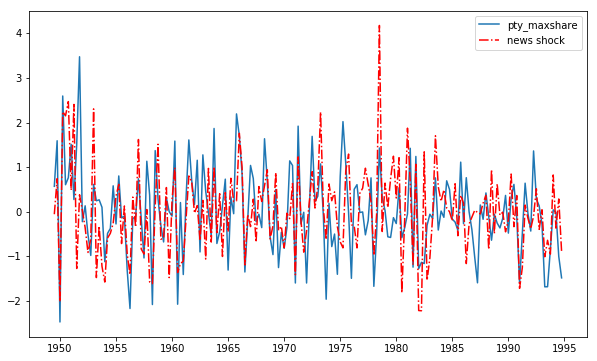

In [21]:
# compare two tech shocks estimated from different approaches 
plt.figure(figsize=(10,6))
plt.plot(str_shocks_est['pty_shock_max'],label='pty_maxshare')
plt.plot(str_shocks_est['news_shock'],'r-.',label='news shock')
plt.legend(loc=1)

In [22]:
print('The correlation coefficient of tech shocks \
identified using max-share approach and the news shock is '+ \
      str(round(str_shocks_est['pty_shock_max'].corr(str_shocks_est['news_shock']),3)))

The correlation coefficient of tech shocks identified using max-share approach and the news shock is 0.515


### Oil shocks (Hamilton 1996)

In [23]:
## loading oil price shocks data 
os_dataM = pd.read_excel('../OtherData/OilShock.xls',sheet_name='data')

## dates 
os_dataM['observation_date'] = pd.to_datetime(os_dataM['observation_date'],format='%Y%m%d')
os_dataM['quarter'] = os_dataM['observation_date'].dt.year.astype(int).astype(str) + \
         "Q" + os_dataM['observation_date'].dt.quarter.astype(int).astype(str)

## compute quarterly shock
os_shockQ  = os_dataM.groupby(['quarter'], sort=False)['OPShock'].max()

## creating quarterly date index
os_datesQ = os_dataM['quarter'].drop_duplicates()
os_datesQ = dates_from_str(os_datesQ)

## prepare quarterly series 
os_shockQ.index = pd.DatetimeIndex(os_datesQ,freq='Q')

## merge with other shocks
str_shocks_est = pd.concat([str_shocks_est,os_shockQ], join='inner', axis=1)

In [24]:
str_shocks_est.tail()

,pty_shock,hours_shock,inf_shock,pty_shock_max,news_shock,OPShock
1993-09-30,-0.468722,-0.435454,-1.061308,-0.841605,-0.953307,0.000000
1993-12-31,-0.492975,0.864681,0.184599,0.039284,0.822784,0.000000
1994-03-31,0.140913,0.040463,-0.715041,-0.018883,-0.370324,0.000000
1994-06-30,-1.496353,0.995196,-0.979459,-1.005738,0.283986,0.000000
1994-09-30,-1.190342,-0.779398,-0.461422,-1.486810,-0.893600,0.013012


### Monetary policy shocks 

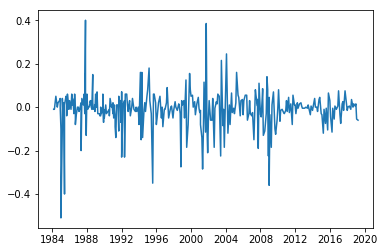

In [25]:
## loading mp shocks data
mps_data = pd.read_excel('../OtherData/2MPShocksJW.xls',sheet_name='data')
mps_data['Date'] = pd.to_datetime(mps_data['Date'],format='%m/%d/%Y')
mps_var = mps_data[['MP1','ED4','ED8']] 

## dates 
mps_datesM = mps_data['Date'].dt.year.astype(int).astype(str) + \
         "M" + mps_data['Date'].dt.month.astype(int).astype(str)
mps_datesM = dates_from_str(mps_datesM)

mps_var.index = pd.DatetimeIndex(mps_datesM)

plt.plot(mps_var['ED4'].dropna())

In [26]:
### save shocks
str_shocks_est.to_stata('../OtherData/InfShocks.dta')